In [1]:
from pennylane import numpy as np
import sys
sys.path.insert(0, '/home/tak/Github/QEmbedding/')
import torch
from torch import nn
import data
import pennylane as qml
import embedding

2023-11-07 15:46:31.129628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.qubit', wires=4)

In [3]:

PATH_Model2 = '/home/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model2 pre-train/Model2_48.pt'
PATH_Model3 = '/home/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model3 pre-train/Model3_48.pt'

In [4]:
class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

model2.load_state_dict(torch.load(PATH_Model2))
model3.load_state_dict(torch.load(PATH_Model3))

<All keys matched successfully>

In [5]:
@qml.qnode(dev)
def overlap_circuit1(x1,x2):
    embedding.Noisy_Four_QuantumEmbedding1(x1)
    embedding.Noisy_Four_QuantumEmbedding1_inverse(x2)
    return qml.probs(wires=range(4))

@qml.qnode(dev)
def overlap_circuit2(x1,x2):
    embedding.Noisy_Four_QuantumEmbedding2(x1)
    embedding.Noisy_Four_QuantumEmbedding2_inverse(x2)
    return qml.probs(wires=range(4))

def kernel(x1, x2, NQE):
    if NQE == False:
        kernel = overlap_circuit1(x1,x2)
    
    
    elif NQE == 'PCA-NQE':
        x1 = model2(torch.tensor(x1))
        x2 = model2(torch.tensor(x2))
        kernel = overlap_circuit2(x1, x2)

    elif NQE == 'NQE':
        x1 = model3(torch.tensor(x1))[0]
        x2 = model3(torch.tensor(x2))[0]
        kernel = overlap_circuit2(x1,x2)
    
    return kernel

  

In [6]:
def get_error_bound(weights, Kernel):
    error_list = []
    for weight in weights:
        Kernel_MP = np.linalg.pinv(Kernel + weight * np.eye(N), hermitian = True)
        error_list.append(np.sqrt(Y_train @ Kernel_MP @ Kernel @ Kernel_MP @ Y_train.T / N))
        
    error_list = np.array(error_list)

    return error_list

QKM without NQE

In [ ]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 4
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel0 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], False)
        Kernel0[i][j] = x[0]
        Kernel0[j][i] = x[0]

In [ ]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel0)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list {k}\n")
f.write(str(error_list))
f.close()

QKM with PCA-NQE

In [ ]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 4
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel2 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "PCA-NQE")
        Kernel2[i][j] = x[0]
        Kernel2[j][i] = x[0]

In [ ]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel2)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list (PCA-NQE) {k}\n")
f.write(str(error_list))
f.close()

QKM with NQE

In [7]:
classes = [0,1]
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0,3,1,2).detach().numpy(), X_test.permute(0,3,1,2).detach().numpy()
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 4
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel3 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "NQE")
        Kernel3[i][j] = x[0]
        Kernel3[j][i] = x[0]

In [9]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel3)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list (NQE) {k}\n")
f.write(str(error_list))
f.close()

In [4]:
weights = np.arange(0.1, 1, 0.1)
error_list0 = [0.34393266, 0.3082718,  0.28615057, 0.27019661, 0.25775887, 0.24758652,
 0.23899382, 0.23156545, 0.22503119, 0.33555984, 0.30042451, 0.27925508, 0.26401796, 0.25213952, 0.24243317,
 0.23424739, 0.22718457, 0.22098395, 0.2938239,  0.26978253, 0.2543934,  0.24307162, 0.2341128,  0.22669507,
 0.22036074, 0.2148296,  0.20991798, 0.33641911, 0.2985513,  0.27665165, 0.26151103, 0.24998878, 0.24068802,
 0.23288086, 0.22614489, 0.22021499, 0.2870103,  0.26489876, 0.25186444, 0.2421597,  0.2342479,  0.22749316,
 0.22156572, 0.21626896, 0.21147415]
error_list2 = [0.11897228, 0.08360172, 0.07040789, 0.06364774, 0.05961526, 0.05697837,
 0.05514254, 0.05380414, 0.05279297, 0.10985471, 0.08340547, 0.07305445, 0.06728415, 0.06353561, 0.06088208,
 0.05889713, 0.05735387, 0.05611915, 0.18553939, 0.13942256, 0.1174671,  0.10422798, 0.09522823, 0.08864113,
 0.08357342, 0.0795333,  0.07622588, 0.13406684, 0.10570568, 0.0927502,  0.08484072, 0.07934844, 0.07524718,
 0.07203892, 0.069447,   0.06730279, 0.12008767, 0.09039785, 0.07776098, 0.07069721, 0.06619806, 0.06309225,
 0.0608252,  0.0591004,  0.05774527]
error_list3 = [0.17405978, 0.1337729,  0.11411599, 0.10209667, 0.09396508, 0.0881059,
 0.08369099, 0.08024945, 0.07749358, 0.19925095, 0.15287096, 0.13000134, 0.11597427, 0.10643205, 0.09950458,
 0.09423934, 0.09009722, 0.08674961, 0.18286738, 0.13999793, 0.11886864, 0.10608277, 0.09753247, 0.09143492,
 0.0868799,  0.0833537,  0.08054514, 0.199743,   0.15488275, 0.13263743, 0.11875099, 0.10913969, 0.10205793,
 0.09660969, 0.09228165, 0.08875673, 0.17802737, 0.137504,   0.11821129, 0.10634961, 0.09820145, 0.09222266,
 0.08763362, 0.08399268, 0.08102928]

error_list0, error_list2, error_list3 = np.array(error_list0), np.array(error_list2), np.array(error_list3)
error_list0 = error_list0.reshape(5,9)
error_list2 = error_list2.reshape(5,9)
error_list3 = error_list3.reshape(5,9)

error_list0_mean, error_list0_std = error_list0.mean(axis=0), error_list0.std(axis=0)
error_list2_mean, error_list2_std = error_list2.mean(axis=0), error_list2.std(axis=0)
error_list3_mean, error_list3_std = error_list3.mean(axis=0), error_list3.std(axis=0)

/tmp/ipykernel_33154/2618341658.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
/tmp/ipykernel_33154/2618341658.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
/tmp/ipykernel_33154/2618341658.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA s

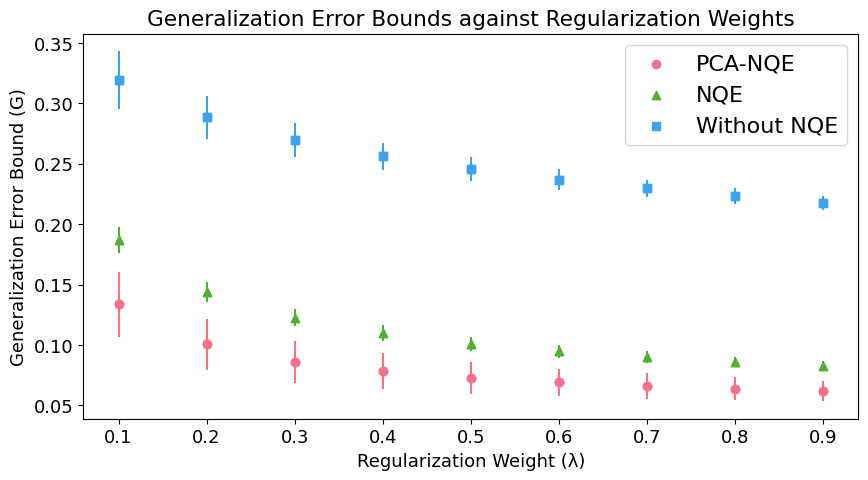

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    
    ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
    ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
    ax.scatter(weights, error_list0_mean, label="Without NQE", marker="s", c=clrs[2])
    
    
    ax.errorbar(weights, error_list2_mean, yerr=error_list2_std, fmt="o", c=clrs[0])
    ax.errorbar(weights, error_list3_mean, yerr=error_list3_std, fmt="^", c=clrs[1])
    ax.errorbar(weights, error_list0_mean, yerr=error_list0_std, fmt="s", c=clrs[2])

ax.set_xlabel("Regularization Weight (λ)")
ax.set_ylabel("Generalization Error Bound (G)")
ax.set_title("Generalization Error Bounds against Regularization Weights")
ax.legend(fontsize=16)
plt.savefig("QKM Generalization.pdf")